In [1]:
!pip install transformers
!pip install tokenizers
!pip install textblob
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 8.0 MB/s 
     |████████████████████████████████| 163 kB 70.4 MB/s 
     |████████████████████████████████| 6.6 MB 40.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import nltk
import time
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel

In [3]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [4]:
train_df = pd.read_csv("train_data.csv")
train_df.head()

,input,labels
0,I am reading score of Mahler is Symphony No . .,0
1,I am not interested in cars or electric applia...,1
2,This is my homework for my English class .,0
3,"In comparison , Canada is catches increased an...",0
4,"Fortunately , my older sister is friend is a d...",1


In [5]:
val_df = pd.read_csv("val_data.csv")
val_df.head()

,input,labels
0,It was the same thing .,0
1,I can study idioms a lot,1
2,I just bet some coins for numbers or colors .,0
3,"Yesterday , I was checking some e - mails on b...",1
4,I regret that I have not played the piano very...,1


In [6]:
test_df = pd.read_csv("test_data.csv")
test_df.head()

,input
0,I believe they will master Japanese soon becau...
1,I am looking for it .
2,Apple is a round fruit with smooth and colorfu...
3,Let It Will Be Push .
4,I rode on this ship from Sendai .


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   19998 non-null  object
 1   labels  19998 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [8]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   10000 non-null  object
 1   labels  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9972 entries, 0 to 9971
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   9972 non-null   object
dtypes: object(1)
memory usage: 78.0+ KB


# EDA

## WordCloud

In [10]:
def draw_wc(data):
  data = " ".join(data.to_numpy().tolist())
  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(stopwords.words("english")),
                min_font_size = 10).generate(data)
  plt.imshow(wordcloud)

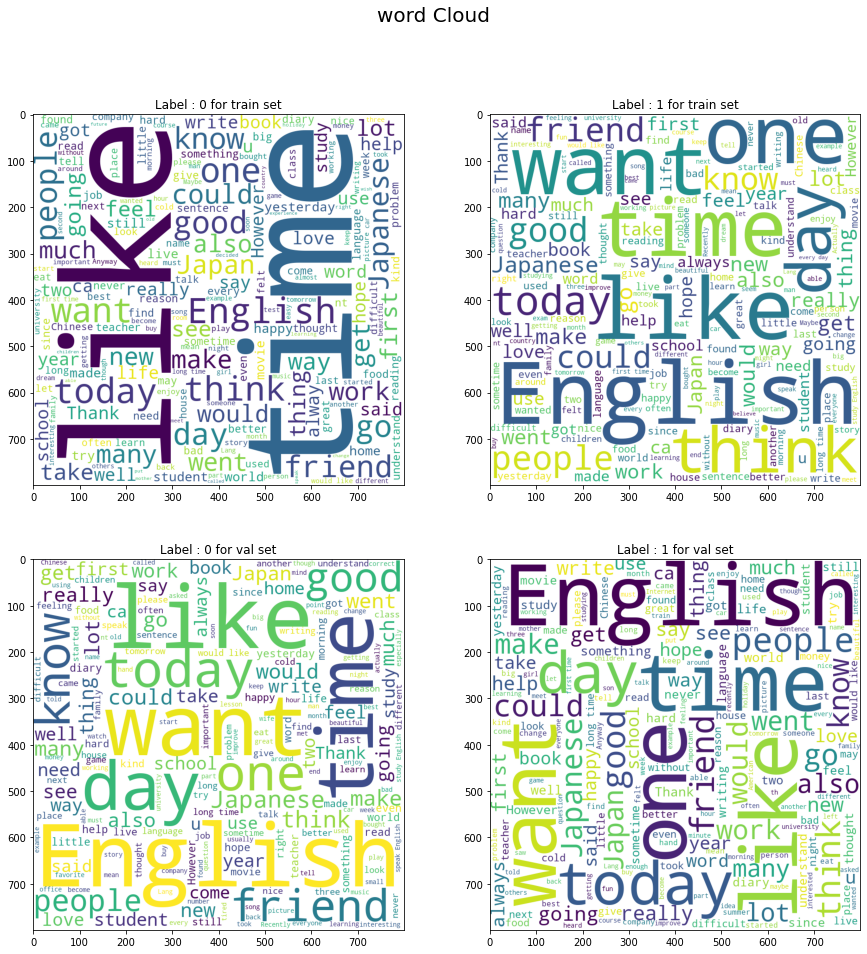

In [11]:
ax, fig = plt.subplots(2, 2, figsize=(15, 15))
plt.suptitle("word Cloud", size=20)
plt.subplot(2,2,1)
draw_wc(train_df[train_df.labels == 0]["input"])
plt.title("Label : 0 for train set")
plt.subplot(2,2,2)
draw_wc(train_df[train_df.labels == 1]["input"])
plt.title("Label : 1 for train set")
plt.subplot(2,2,3)
draw_wc(val_df[val_df.labels == 0]["input"])
plt.title("Label : 0 for val set")
plt.subplot(2,2,4)
draw_wc(val_df[val_df.labels == 1]["input"])
plt.title("Label : 1 for val set")
plt.show()

## Spell Check

In [12]:
def remove_reduntant_symbols(text):
    text = text.replace(".", "")
    text = text.replace(",", "")
    text = text.replace("'", "")
    return text

In [13]:
def check_spelling_per_word(text):
  text = remove_reduntant_symbols(text)
  flag = True
  for word in text:
    if word != TextBlob(word).correct():
      flag = False
      break
  return flag

In [14]:
train_df["spell_check"] = train_df["input"].apply(check_spelling_per_word)
train_df.head()

,input,labels,spell_check
0,I am reading score of Mahler is Symphony No . .,0,True
1,I am not interested in cars or electric applia...,1,True
2,This is my homework for my English class .,0,True
3,"In comparison , Canada is catches increased an...",0,True
4,"Fortunately , my older sister is friend is a d...",1,True


In [15]:
val_df["spell_check"] = val_df["input"].apply(check_spelling_per_word)
val_df.head()

,input,labels,spell_check
0,It was the same thing .,0,True
1,I can study idioms a lot,1,True
2,I just bet some coins for numbers or colors .,0,True
3,"Yesterday , I was checking some e - mails on b...",1,True
4,I regret that I have not played the piano very...,1,True


In [16]:
train_df.spell_check.value_counts()

True    19998
Name: spell_check, dtype: int64

In [17]:
val_df.spell_check.value_counts()

True    10000
Name: spell_check, dtype: int64

In [18]:
def check_spelling_per_sent(text):
  text = remove_reduntant_symbols(text)
  return text == TextBlob(text).correct()

In [19]:
train_df["spell_check_whole_sent"] = train_df["input"].apply(check_spelling_per_sent)
train_df.head()

,input,labels,spell_check,spell_check_whole_sent
0,I am reading score of Mahler is Symphony No . .,0,True,False
1,I am not interested in cars or electric applia...,1,True,True
2,This is my homework for my English class .,0,True,False
3,"In comparison , Canada is catches increased an...",0,True,False
4,"Fortunately , my older sister is friend is a d...",1,True,True


In [20]:
val_df["spell_check_whole_sent"] = val_df["input"].apply(check_spelling_per_word)
train_df.head()

,input,labels,spell_check,spell_check_whole_sent
0,I am reading score of Mahler is Symphony No . .,0,True,False
1,I am not interested in cars or electric applia...,1,True,True
2,This is my homework for my English class .,0,True,False
3,"In comparison , Canada is catches increased an...",0,True,False
4,"Fortunately , my older sister is friend is a d...",1,True,True


In [21]:
train_df.groupby(["spell_check_whole_sent", "labels"]).count()

input  spell_check
spell_check_whole_sent labels                    
False                  0        3968         3968
                       1        3644         3644
True                   0        6031         6031
                       1        6355         6355

In [22]:
val_df.groupby(["spell_check_whole_sent", "labels"]).count()

input  spell_check
spell_check_whole_sent labels                    
True                   0        5000         5000
                       1        5000         5000

## Feature Generation

In [23]:
# tokenizer for the task
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer.model_max_length = 300

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [24]:
class BERTDatasetTraining:

    def __init__(self, meta_df, seq_len = 512):

        self.meta_df = pd.read_csv(meta_df)
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.meta_df["proc_text"] = self.meta_df["input"].apply(remove_reduntant_symbols)

    def __len__(self):
        return len(self.meta_df)

    def __getitem__(self, index):
        sentence = self.meta_df.loc[index,"proc_text"]
        label = self.meta_df.loc[index, "labels"]
        # encoding texts
        tokens = tokenizer.encode_plus(sentence, padding="max_length", truncation=True)

        # adding padding to the right of dataset
        pad_len = max(0, self.seq_len - len(tokens["input_ids"]))
        tokens["input_ids"] += [0 for _ in range(pad_len)]
        tokens["attention_mask"] += [0 for _ in range(pad_len)]
        tokens["token_type_ids"] += [0 for _ in range(pad_len)]

        return {
            "index": torch.tensor(index, dtype=torch.int),
            "input_ids" : torch.tensor(tokens["input_ids"], dtype=torch.long),
            "attention_mask" : torch.tensor(tokens["attention_mask"], dtype=torch.long),
            "token_type_ids" : torch.tensor(tokens["token_type_ids"], dtype=torch.long),
            "target" : torch.tensor(label, dtype=torch.long)
        }

class BERTDatasetTesting:

    def __init__(self, meta_df, seq_len = 512):

        self.meta_df = pd.read_csv(meta_df)
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.meta_df["proc_text"] = self.meta_df["input"].apply(remove_reduntant_symbols)

    def __len__(self):
        return len(self.meta_df)

    def __getitem__(self, index):
        sentence = self.meta_df.loc[index,"proc_text"]
        # encoding texts
        tokens = tokenizer.encode_plus(sentence, padding="max_length", truncation=True)

        # adding padding to the right of dataset
        pad_len = max(0, self.seq_len - len(tokens["input_ids"]))
        tokens["input_ids"] += [0 for _ in range(pad_len)]
        tokens["attention_mask"] += [0 for _ in range(pad_len)]
        tokens["token_type_ids"] += [0 for _ in range(pad_len)]

        return {
            "index": torch.tensor(index, dtype=torch.int),
            "input_ids" : torch.tensor(tokens["input_ids"], dtype=torch.long),
            "attention_mask" : torch.tensor(tokens["attention_mask"], dtype=torch.long),
            "token_type_ids" : torch.tensor(tokens["token_type_ids"], dtype=torch.long)
        }

In [25]:
train_ds = BERTDatasetTraining("train_data.csv", seq_len=300)
val_ds = BERTDatasetTraining("val_data.csv", seq_len=300)
test_ds = BERTDatasetTesting("test_data.csv", seq_len=300)

In [26]:
train_dl = DataLoader(train_ds, batch_size = 2, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = 2, shuffle=True)
test_dl = DataLoader(test_ds, batch_size = 2, shuffle=False)

In [27]:
base_featurizer = BertModel.from_pretrained("bert-base-cased")
base_featurizer

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [28]:
base_featurizer = base_featurizer.cuda()

In [29]:
def prepare_data(base_df, dl, test=False):
  op_arr = None
  ind_arr = None
  for batch in tqdm(dl):
      _, op = base_featurizer(batch["input_ids"].cuda(),
                                  attention_mask = batch["attention_mask"].cuda(),
                                  token_type_ids = batch["token_type_ids"].cuda(), return_dict=False)
      op = op.cpu().detach().numpy()
      ind = batch["index"].detach().numpy()
      if op_arr is not None:
          op_arr = np.vstack([op_arr, op])
          ind_arr = np.vstack([ind_arr, ind])
      else:
          op_arr = op
          ind_arr = ind
  fet_df = pd.DataFrame(op_arr)
  fet_df["index"] = ind_arr.flatten()
  fet_df = fet_df.sort_values("index").reset_index(drop=True)
  if test == False:
    fet_df["label"] = base_df["labels"]

  return fet_df

In [32]:
train_fet_df = prepare_data(train_df, train_dl)
train_fet_df.head(5)

100%|██████████| 9999/9999 [07:40<00:00, 21.71it/s]


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,index,label
0,-0.682434,0.388947,0.999761,-0.988015,0.920290,0.955576,0.931116,-0.994874,-0.926118,-0.439471,...,0.534318,-0.787176,-0.465252,-0.581656,-0.228486,0.999925,-0.833729,0.967324,0,0
1,-0.695644,0.440705,0.999919,-0.994828,0.967682,0.919735,0.992490,-0.990897,-0.983042,-0.654550,...,0.729104,-0.504304,-0.316376,-0.435336,-0.106231,0.999968,-0.845126,0.991400,1,1
2,-0.725342,0.436208,0.999817,-0.994033,0.945838,0.957559,0.977897,-0.995467,-0.973820,-0.650113,...,0.532920,-0.634500,-0.237084,-0.386203,-0.022754,0.999956,-0.843400,0.991820,2,0
3,-0.555574,0.499562,0.999815,-0.987642,0.931760,0.699627,0.979408,-0.948547,-0.954020,-0.823417,...,0.356360,-0.133309,0.015997,-0.152413,-0.243595,0.999916,-0.470678,0.971472,3,0
4,-0.691290,0.371473,0.999731,-0.993522,0.955854,0.950515,0.975778,-0.994283,-0.977120,-0.573242,...,0.557885,-0.450582,-0.237969,-0.378430,-0.097172,0.999931,-0.910964,0.987042,4,1


In [33]:
val_fet_df = prepare_data(val_df, val_dl)
val_fet_df.head()

100%|██████████| 5000/5000 [03:36<00:00, 23.06it/s]


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,index,label
0,-0.649464,0.492665,0.999944,-0.998024,0.981995,0.930549,0.996899,-0.997415,-0.990756,-0.670527,...,0.766731,-0.724997,-0.387786,-0.715676,-0.086336,0.999984,-0.881857,0.995620,0,0
1,-0.744232,0.426219,0.999952,-0.997502,0.973657,0.909176,0.993637,-0.990495,-0.986465,-0.761426,...,0.691438,-0.541935,-0.335869,-0.246163,-0.093606,0.999987,-0.844223,0.994685,1,1
2,-0.622260,0.452945,0.999842,-0.995074,0.952345,0.937106,0.984170,-0.994058,-0.978999,-0.708661,...,0.645354,-0.677208,-0.315659,-0.501399,-0.151309,0.999960,-0.881041,0.994014,2,0
3,-0.705142,0.399240,0.999612,-0.992516,0.946544,0.964092,0.975264,-0.998362,-0.966763,-0.598765,...,0.650131,-0.586366,-0.305075,-0.553595,-0.034119,0.999899,-0.915478,0.988257,3,1
4,-0.754545,0.479804,0.999949,-0.997157,0.971919,0.939552,0.992239,-0.986046,-0.987488,-0.615482,...,0.503835,-0.419555,-0.124159,-0.123385,-0.220606,0.999985,-0.770697,0.991962,4,1


In [34]:
test_fet_df = prepare_data(test_df, test_dl, test=True)
test_fet_df.head()

100%|██████████| 4986/4986 [03:42<00:00, 22.40it/s]


,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,index
0,-0.795346,0.450019,0.999895,-0.995306,0.958765,0.839780,0.985694,-0.979571,-0.981592,-0.606088,...,-0.092873,0.458135,-0.343935,-0.126171,-0.217619,-0.241989,0.999971,-0.764177,0.987010,0
1,-0.665356,0.394326,0.999791,-0.992230,0.963121,0.951114,0.976866,-0.997325,-0.957013,-0.630562,...,-0.533416,0.624038,-0.633145,-0.513624,-0.558716,-0.074403,0.999920,-0.881798,0.989865,1
2,-0.672799,0.413409,0.999897,-0.994134,0.956795,0.744205,0.984871,-0.971637,-0.957055,-0.783233,...,-0.166936,0.505205,-0.224273,-0.402042,0.015208,-0.154986,0.999949,-0.708484,0.987508,2
3,-0.677084,0.470728,0.999728,-0.988789,0.926394,0.909892,0.965819,-0.994012,-0.954312,-0.496845,...,-0.569263,0.648254,-0.750622,-0.416092,-0.488988,-0.274212,0.999926,-0.814197,0.975097,3
4,-0.666310,0.283904,0.999641,-0.991182,0.894244,0.942348,0.936871,-0.995157,-0.912563,-0.523216,...,-0.284870,0.388844,-0.230037,-0.462788,-0.592975,-0.193065,0.999938,-0.802377,0.983323,4


In [35]:
X_train = train_fet_df.drop(["index", "label"], axis=1)
y_train = train_fet_df["label"]
X_val = val_fet_df.drop(["index", "label"], axis=1)
y_val = val_fet_df["label"]
X_test = test_fet_df.drop("index",1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


## High-Level Feature Distribution:

In [36]:
def draw_feature_structure_tsne(data, y, n_components=3):
  time_start = time.time()
  tsne = TSNE(n_components=n_components, verbose=1, perplexity=40, n_iter=300)
  tsne_results = tsne.fit_transform(data)
  df = pd.DataFrame()
  df['x0'] = tsne_results[:,0]
  df['y0'] = tsne_results[:,1]
  df["z0"] = tsne_results[:,2]
  df['target'] = y
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')
  ax.scatter(
      xs=df["x0"], 
      ys=df["y0"], 
      zs=df["z0"], 
      c=df["target"], 
      cmap='tab10'
  )
  ax.set_xlabel('tsne-one')
  ax.set_ylabel('tsne-two')
  ax.set_zlabel('tsne-three')
  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 19998 samples in 0.032s...
[t-SNE] Computed neighbors for 19998 samples in 31.139s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19998
[t-SNE] Computed conditional probabilities for sample 2000 / 19998
[t-SNE] Computed conditional probabilities for sample 3000 / 19998
[t-SNE] Computed conditional probabilities for sample 4000 / 19998
[t-SNE] Computed conditional probabilities for sample 5000 / 19998
[t-SNE] Computed conditional probabilities for sample 6000 / 19998
[t-SNE] Computed conditional probabilities for sample 7000 / 19998
[t-SNE] Computed conditional probabilities for sample 8000 / 19998
[t-SNE] Computed conditional probabilities for sample 9000 / 19998
[t-SNE] Computed conditional probabilities for sample 10000 / 19998
[t-SNE] Computed conditional probabilities for sample 11000 / 19998
[t-SNE] Computed conditional probabilities for sample 12000 / 19998
[t-SNE] Computed conditional probabilities for s

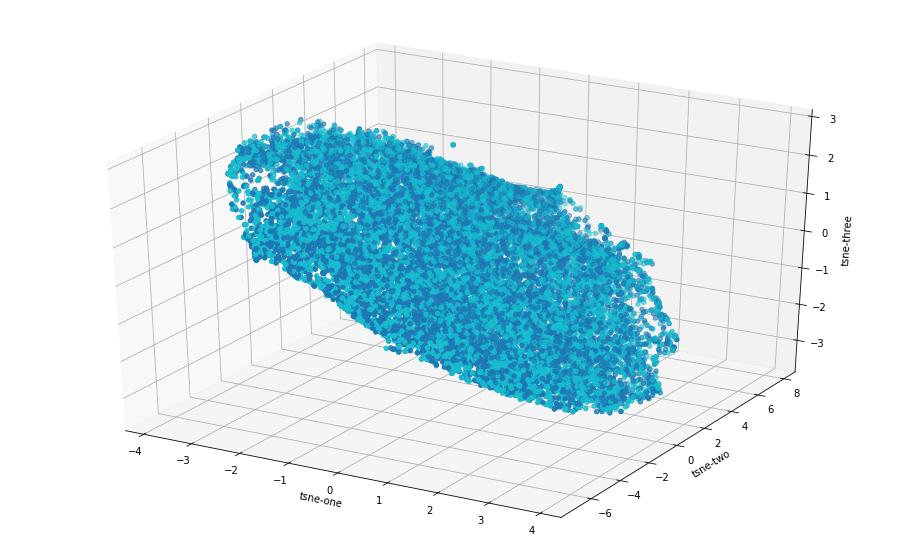

In [37]:
draw_feature_structure_tsne(X_train,y_train,3)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.015s...
[t-SNE] Computed neighbors for 10000 samples in 8.947s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.622981
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.086349
[t-SNE] KL divergence after 300 iterations: 3.002069


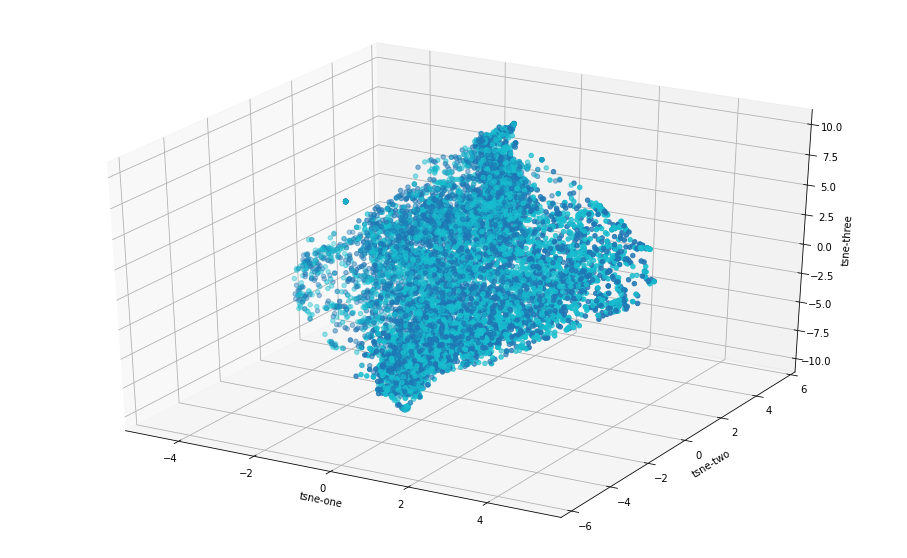

In [38]:
draw_feature_structure_tsne(X_val,y_val,3)

In [39]:
def draw_feature_structure_pca(data, y, n_components=3):
  pca = PCA(n_components=n_components)
  pca_result = pca.fit_transform(data)
  df = pd.DataFrame()
  df['pca-one'] = pca_result[:,0]
  df['pca-two'] = pca_result[:,1] 
  df['pca-three'] = pca_result[:,2]
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')
  ax.scatter(
      xs=df["pca-one"], 
      ys=df["pca-two"], 
      zs=df["pca-three"], 
      c=y, 
      cmap='tab10'
  )
  ax.set_xlabel('pca-one')
  ax.set_ylabel('pca-two')
  ax.set_zlabel('pca-three')
  plt.show()

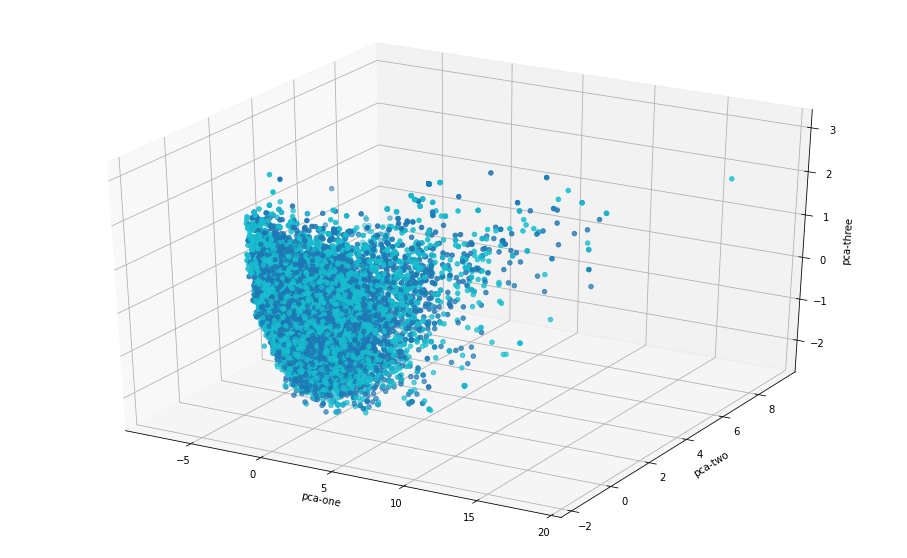

In [41]:
draw_feature_structure_pca(X_train, y_train)

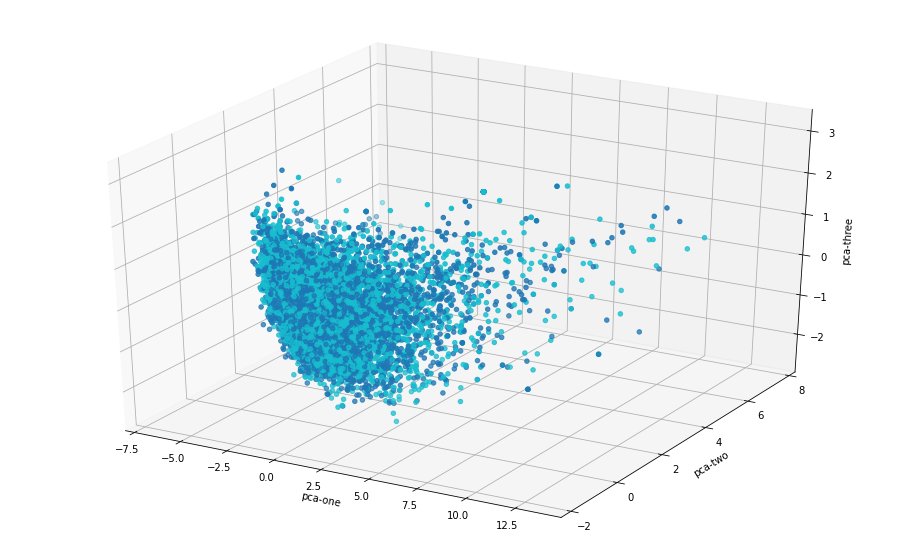

In [42]:
draw_feature_structure_pca(X_val, y_val)

In [53]:
from sklearn.ensemble import RandomForestClassifier as rfc
from xgboost import XGBClassifier as xgb
from sklearn.naive_bayes import GaussianNB, MultinomialNB as mnb
from lightgbm import LGBMClassifier as lgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold

In [56]:
def train_and_check_results(x, y, val_x, val_y, model):
  model.fit(x,y)
  train_pred = model.predict(x)
  print(f"Training results : \n{classification_report(y, train_pred)}\n{confusion_matrix(y, train_pred)}")
  val_pred = model.predict(val_x)
  print(f"Validation results : \n{classification_report(val_y, val_pred)}\n{confusion_matrix(val_y, val_pred)}")
  return model

In [58]:
base_train_model = train_and_check_results(X_train, y_train, X_val, y_val, rfc())

Training results : 
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      9999
           1       0.87      0.88      0.87      9999

    accuracy                           0.87     19998
   macro avg       0.87      0.87      0.87     19998
weighted avg       0.87      0.87      0.87     19998

[[8691 1308]
 [1217 8782]]
Validation results : 
              precision    recall  f1-score   support

           0       0.40      0.39      0.40      5000
           1       0.41      0.42      0.42      5000

    accuracy                           0.41     10000
   macro avg       0.41      0.41      0.41     10000
weighted avg       0.41      0.41      0.41     10000

[[1966 3034]
 [2890 2110]]


In [59]:
base_val_model = train_and_check_results(X_val, y_val, X_train, y_train, rfc())

Training results : 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      5000
           1       0.94      0.94      0.94      5000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

[[4682  318]
 [ 315 4685]]
Validation results : 
              precision    recall  f1-score   support

           0       0.48      0.47      0.47      9999
           1       0.48      0.49      0.48      9999

    accuracy                           0.48     19998
   macro avg       0.48      0.48      0.48     19998
weighted avg       0.48      0.48      0.48     19998

[[4669 5330]
 [5135 4864]]


In [62]:
def fold_training(x, y, model, n_splits):
  kf = KFold(n_splits=n_splits)
  models = []
  for tr_index, ts_index in kf.split(x):
    xtr = x.iloc[tr_index]
    ytr = y.iloc[tr_index]
    xvl = x.iloc[ts_index]
    yvl = y.iloc[ts_index]
    models.append(train_and_check_results(xtr, ytr, xvl, yvl, model))
  return models

In [65]:
rfc_models_train = fold_training(X_train, y_train, rfc(), 10)

Training results : 
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      8975
           1       0.88      0.90      0.89      9023

    accuracy                           0.89     17998
   macro avg       0.89      0.89      0.89     17998
weighted avg       0.89      0.89      0.89     17998

[[7888 1087]
 [ 939 8084]]
Validation results : 
              precision    recall  f1-score   support

           0       0.40      0.38      0.39      1024
           1       0.38      0.41      0.40       976

    accuracy                           0.39      2000
   macro avg       0.39      0.39      0.39      2000
weighted avg       0.39      0.39      0.39      2000

[[386 638]
 [577 399]]
Training results : 
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      8974
           1       0.88      0.89      0.89      9024

    accuracy                           0.88     17998
   macro avg    

In [66]:
rfc_models_val = fold_training(X_val, y_val, rfc(), 5)

Training results : 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4010
           1       0.95      0.95      0.95      3990

    accuracy                           0.95      8000
   macro avg       0.95      0.95      0.95      8000
weighted avg       0.95      0.95      0.95      8000

[[3791  219]
 [ 202 3788]]
Validation results : 
              precision    recall  f1-score   support

           0       0.49      0.50      0.49       990
           1       0.50      0.50      0.50      1010

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000

[[492 498]
 [508 502]]
Training results : 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4023
           1       0.95      0.95      0.95      3977

    accuracy                           0.95      8000
   macro avg    

In [67]:
xgb_models_train = fold_training(X_train, y_train, xgb(), 10)

Training results : 
              precision    recall  f1-score   support

           0       0.66      0.58      0.62      8975
           1       0.63      0.71      0.66      9023

    accuracy                           0.64     17998
   macro avg       0.65      0.64      0.64     17998
weighted avg       0.65      0.64      0.64     17998

[[5220 3755]
 [2660 6363]]
Validation results : 
              precision    recall  f1-score   support

           0       0.54      0.48      0.51      1024
           1       0.51      0.57      0.54       976

    accuracy                           0.53      2000
   macro avg       0.53      0.53      0.52      2000
weighted avg       0.53      0.53      0.52      2000

[[492 532]
 [418 558]]
Training results : 
              precision    recall  f1-score   support

           0       0.66      0.59      0.62      8974
           1       0.63      0.71      0.67      9024

    accuracy                           0.65     17998
   macro avg    

In [69]:
xgb_models_val = fold_training(X_val, y_val, xgb(), 5)

Training results : 
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      4010
           1       0.72      0.76      0.74      3990

    accuracy                           0.73      8000
   macro avg       0.73      0.73      0.73      8000
weighted avg       0.73      0.73      0.73      8000

[[2816 1194]
 [ 972 3018]]
Validation results : 
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       990
           1       0.55      0.54      0.54      1010

    accuracy                           0.54      2000
   macro avg       0.54      0.54      0.54      2000
weighted avg       0.54      0.54      0.54      2000

[[536 454]
 [463 547]]
Training results : 
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      4023
           1       0.71      0.75      0.73      3977

    accuracy                           0.72      8000
   macro avg    

In [70]:
gnb_models_train = fold_training(X_train, y_train, GaussianNB(), 10)

Training results : 
              precision    recall  f1-score   support

           0       0.52      0.79      0.63      8975
           1       0.56      0.26      0.35      9023

    accuracy                           0.53     17998
   macro avg       0.54      0.53      0.49     17998
weighted avg       0.54      0.53      0.49     17998

[[7124 1851]
 [6683 2340]]
Validation results : 
              precision    recall  f1-score   support

           0       0.52      0.78      0.62      1024
           1       0.51      0.24      0.32       976

    accuracy                           0.52      2000
   macro avg       0.51      0.51      0.47      2000
weighted avg       0.51      0.52      0.48      2000

[[800 224]
 [746 230]]
Training results : 
              precision    recall  f1-score   support

           0       0.50      0.93      0.65      8974
           1       0.53      0.07      0.13      9024

    accuracy                           0.50     17998
   macro avg    

In [71]:
gnb_models_val = fold_training(X_val, y_val, GaussianNB(), 5)

Training results : 
              precision    recall  f1-score   support

           0       0.50      0.89      0.64      4010
           1       0.49      0.10      0.17      3990

    accuracy                           0.50      8000
   macro avg       0.50      0.50      0.41      8000
weighted avg       0.50      0.50      0.41      8000

[[3584  426]
 [3581  409]]
Validation results : 
              precision    recall  f1-score   support

           0       0.50      0.92      0.65       990
           1       0.57      0.11      0.18      1010

    accuracy                           0.51      2000
   macro avg       0.54      0.51      0.42      2000
weighted avg       0.54      0.51      0.41      2000

[[907  83]
 [900 110]]
Training results : 
              precision    recall  f1-score   support

           0       0.50      0.88      0.64      4023
           1       0.49      0.12      0.19      3977

    accuracy                           0.50      8000
   macro avg    

In [73]:
mnb_models_train = fold_training(X_train+1, y_train, mnb(), 10)

Training results : 
              precision    recall  f1-score   support

           0       0.54      0.44      0.48      8975
           1       0.53      0.64      0.58      9023

    accuracy                           0.54     17998
   macro avg       0.54      0.54      0.53     17998
weighted avg       0.54      0.54      0.53     17998

[[3913 5062]
 [3284 5739]]
Validation results : 
              precision    recall  f1-score   support

           0       0.55      0.42      0.48      1024
           1       0.52      0.65      0.57       976

    accuracy                           0.53      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.54      0.53      0.52      2000

[[431 593]
 [346 630]]
Training results : 
              precision    recall  f1-score   support

           0       0.53      0.43      0.48      8974
           1       0.52      0.61      0.56      9024

    accuracy                           0.52     17998
   macro avg    

In [74]:
mnb_models_val = fold_training(X_val+1, y_val, mnb(), 5)

Training results : 
              precision    recall  f1-score   support

           0       0.53      0.44      0.48      4010
           1       0.52      0.60      0.56      3990

    accuracy                           0.52      8000
   macro avg       0.52      0.52      0.52      8000
weighted avg       0.52      0.52      0.52      8000

[[1775 2235]
 [1591 2399]]
Validation results : 
              precision    recall  f1-score   support

           0       0.53      0.45      0.49       990
           1       0.53      0.60      0.56      1010

    accuracy                           0.53      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.53      0.53      0.53      2000

[[448 542]
 [400 610]]
Training results : 
              precision    recall  f1-score   support

           0       0.52      0.45      0.48      4023
           1       0.51      0.58      0.55      3977

    accuracy                           0.52      8000
   macro avg    

In [75]:
lgb_models_train = fold_training(X_train, y_train, lgb(), 10)

Training results : 
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      8975
           1       0.78      0.85      0.81      9023

    accuracy                           0.80     17998
   macro avg       0.81      0.80      0.80     17998
weighted avg       0.81      0.80      0.80     17998

[[6807 2168]
 [1358 7665]]
Validation results : 
              precision    recall  f1-score   support

           0       0.47      0.42      0.44      1024
           1       0.45      0.49      0.47       976

    accuracy                           0.46      2000
   macro avg       0.46      0.46      0.46      2000
weighted avg       0.46      0.46      0.46      2000

[[432 592]
 [496 480]]
Training results : 
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      8974
           1       0.78      0.85      0.81      9024

    accuracy                           0.80     17998
   macro avg    

In [76]:
lgb_models_val = fold_training(X_val, y_val, lgb(), 5)

Training results : 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4010
           1       0.93      0.93      0.93      3990

    accuracy                           0.93      8000
   macro avg       0.93      0.93      0.93      8000
weighted avg       0.93      0.93      0.93      8000

[[3719  291]
 [ 271 3719]]
Validation results : 
              precision    recall  f1-score   support

           0       0.49      0.50      0.50       990
           1       0.50      0.50      0.50      1010

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000

[[494 496]
 [508 502]]
Training results : 
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      4023
           1       0.93      0.94      0.93      3977

    accuracy                           0.93      8000
   macro avg    

In [83]:
def prepare_submission(validation_data, testing_data, model, op_name):
  x,y = validation_data
  pred = model.predict(x)
  print(classification_report(y, pred))
  print(f"Condusion Matrix : {confusion_matrix(y, pred)}")
  pred = model.predict(testing_data)
  sub_df = pd.DataFrame({"input": test_df["input"], "labels": pred})
  sub_df.to_csv(f"submission_{op_name}.csv", index=False)

In [79]:
prepare_submission((X_val, y_val), X_test, rfc_models_train[4], "rfc_train")

              precision    recall  f1-score   support

           0       0.41      0.41      0.41      5000
           1       0.42      0.42      0.42      5000

    accuracy                           0.42     10000
   macro avg       0.42      0.42      0.42     10000
weighted avg       0.42      0.42      0.42     10000

Condusion Matrix : [[2039 2961]
 [2880 2120]]


In [80]:
prepare_submission((X_train, y_train), X_test, rfc_models_val[0], "rfc_val")

              precision    recall  f1-score   support

           0       0.49      0.48      0.48      9999
           1       0.49      0.50      0.50      9999

    accuracy                           0.49     19998
   macro avg       0.49      0.49      0.49     19998
weighted avg       0.49      0.49      0.49     19998

Condusion Matrix : [[4776 5223]
 [4983 5016]]


In [81]:
prepare_submission((X_val, y_val), X_test, xgb_models_train[5], "xgb_train")

              precision    recall  f1-score   support

           0       0.54      0.49      0.52      5000
           1       0.54      0.58      0.56      5000

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.54      0.54      0.54     10000

Condusion Matrix : [[2465 2535]
 [2076 2924]]


In [82]:
prepare_submission((X_train, y_train), X_test, xgb_models_val[4], "xgb_val")

              precision    recall  f1-score   support

           0       0.54      0.50      0.52      9999
           1       0.53      0.57      0.55      9999

    accuracy                           0.53     19998
   macro avg       0.53      0.53      0.53     19998
weighted avg       0.53      0.53      0.53     19998

Condusion Matrix : [[4993 5006]
 [4303 5696]]


In [84]:
prepare_submission((X_val, y_val), X_test, gnb_models_train[5], "gnb_train")

              precision    recall  f1-score   support

           0       0.51      0.81      0.62      5000
           1       0.53      0.21      0.30      5000

    accuracy                           0.51     10000
   macro avg       0.52      0.51      0.46     10000
weighted avg       0.52      0.51      0.46     10000

Condusion Matrix : [[4065  935]
 [3944 1056]]


In [85]:
prepare_submission((X_train, y_train), X_test, gnb_models_val[0], "gnb_val")

              precision    recall  f1-score   support

           0       0.50      0.90      0.64      9999
           1       0.52      0.11      0.18      9999

    accuracy                           0.50     19998
   macro avg       0.51      0.50      0.41     19998
weighted avg       0.51      0.50      0.41     19998

Condusion Matrix : [[8990 1009]
 [8927 1072]]


In [90]:
prepare_submission((X_val, y_val), X_test, mnb_models_train[5], "mnb_train")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5000
           1       0.50      1.00      0.67      5000

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000

Condusion Matrix : [[   0 5000]
 [   0 5000]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
prepare_submission((X_train, y_train), X_test, mnb_models_val[3], "mnb_val")

              precision    recall  f1-score   support

           0       0.60      0.00      0.00      9999
           1       0.50      1.00      0.67      9999

    accuracy                           0.50     19998
   macro avg       0.55      0.50      0.34     19998
weighted avg       0.55      0.50      0.34     19998

Condusion Matrix : [[  18 9981]
 [  12 9987]]


In [88]:
prepare_submission((X_val, y_val), X_test, lgb_models_train[9], "lgb_train")

              precision    recall  f1-score   support

           0       0.46      0.43      0.44      5000
           1       0.46      0.50      0.48      5000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000
weighted avg       0.46      0.46      0.46     10000

Condusion Matrix : [[2134 2866]
 [2516 2484]]


In [89]:
prepare_submission((X_train, y_train), X_test, lgb_models_val[4], "lgb_val")

              precision    recall  f1-score   support

           0       0.49      0.49      0.49      9999
           1       0.49      0.50      0.50      9999

    accuracy                           0.49     19998
   macro avg       0.49      0.49      0.49     19998
weighted avg       0.49      0.49      0.49     19998

Condusion Matrix : [[4873 5126]
 [5019 4980]]


The Extreme Gradient Boosting has been chosen as the best model when trained on the training set and chosen for preparation of final results